# Create custom equi-depth histogrammers

SPCSim provides 4t EDH implementations `BaseEDHSPC`, `HEDHBaseClass`, `PEDHBaseClass` and `PEDHOptimized`. The HEDHBaseClass and PEDHBaseClass inherit BaseEDHSPC class and PEDHOptimized inherits PEDHBaseClass.


The BaseEDHSPC returns the ground truth EDH `gtedh` and Oracle EDH `oedh`. gtedh is the ED histogram for the known/simulated true transient and oedh is the ED histogram computed after storing all the photon timestamps captured by the SPC hence the term 'oracle'.

To create a variant of HEDH or PEDH, inheriting the respective base classes is a good start. HEDH and PEDH have some fundamental differences in their operation which justifice the design choice of creating two differen base classes.

The EDH class methods modularize the task of creating new variants of EDH. Some of the methods and their functionalities are as follows:

## BaseEDHSPC class methods

* `get_ts_from_hist` : Use this method to convert the one-hot encoded photon detection vectors to photon time-stamps which can later be used to compute the early and late photons.

* `capture` : The capture method is inherited from the `BaseDtofSPC` class and needs to be overwritten when creating a fundamentally new EDH. For example `HEDHBaseClass`, `PEDHBaseClass` overwrite different implementations of the capture method but the `PEDHOptimized` class inherits the capture method of `PEDHBaseClass` instead of overwriting it.

* `ewh2edh`: This method is used to compute the ED histogram from a captured EW histogram.


## HEDHBaseClass methods and attributes

* `set_idx_lists`: Method to initialize indxing lists.

* `clip_left` and `clip_right`: These lists are useful to compute the early and late photon streams following the hierachical flow.

* `set_decay_schedule` is called in the class constructor and is used to create different decay schedules to reduce the overall step size over time hence reducing the standard deviation in CV values over time.

* `update_edh`: Main method that determines how the CV values of EDH binners are updated. Any variant o f update_edh will have similar outline:

  * Call `update_delta_mask` to enable or disable updates to the CV value of different binner. For a pixel in i^th row and j^th column setting delta_mask[i,j,k] = 0 will disable any updates to the k^th binboundary.

  * Get the timestamp vector using `get_ts_from_hist`.

  * Compute the early and late photons using `update_pa_pb_kp`.

  * Compute `delta`, the ratio of difference between in early and late photons to the total photons using `update_delta`.

  * Depending on the stepping strategy you can use the value of `delta` to compute the final step size for all the binners and save it in attribute `prev_step`.

  * Finally use `apply_edh_step` and increment the laser cycle counter `cy_cnt` by one and return the updated EDH boundary values stored in `e1`.

Most methods are common for `HEDHBaseClass` and `PEDHBaseClass` but with some difference in the implementation based on the inherent nature of how they work.

In [ ]:
SPCSim
pip install .

## Creating a custom HEDH variant1


**Setting up the experiment**

Setting the distance = 0.1 of maximum distance, laser pulse width FWHM = 2ns. Creating PerPixelLoader and TransientGenerator objects to simulate true transient for specific scene distance and signal-background photon flux.

In [28]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils import plot_transient
import matplotlib.pyplot as plt
from SPCSim.sensors.dtof import HEDHBaseClass, PEDHBaseClass
import torch
from SPCSim.utils.plot_utils import plot_transient, plot_edh, plot_edh_traj
from SPCSim.postproc.edh_postproc import PostProcEDH
import numpy as np

min_dist = 0.1
FWHM = 3
N_edhbins = 8
N_pulses = 2000


# Simulating results for distance = 0.1*dmax
PixLdr = PerPixelLoader(min_dist = min_dist,
                        tmax = 100,
                        sig_bkg_list = [
                            [1.0,2.0]],
                        device = "cpu")

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(N_tbins = 1000, tmax = PixLdr.tmax, FWHM = FWHM)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                              data["albedo"],
                              data["albedo"],
                              data["alpha_sig"],
                              data["alpha_bkg"])


# Setting the dimensions, device, number of EWH bins per pixel
# and number of laser pulses

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device


**Implementing HEDH variant 1**

First example is a simple variant of HEDH where each binner updates the step size by 1 and all levels run for the complete exposure time.

In [23]:

# Crearting the HEDH variant class
class HEDHVariant1(HEDHBaseClass):
  def __init__(self,
               Nr,
               Nc,
               N_pulses,
               device,
               N_tbins,
               N_edhbins,
               dead_time = 0,
               seed = 0,
               save_traj = True,
               pix_r = 0,
               pix_c = 0,
               step_params = {}):
    HEDHBaseClass.__init__(
              self,
              Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              seed = seed,
              save_traj = save_traj,
              pix_r = pix_r,
              pix_c = pix_c,
              step_params = step_params)

  # Overloading method to set the step size = 1 for all the laser cycles. Unlike
  # baseclass this removes the requirement of N_pulses to be multiple of N_levels
  def set_decay_schedule(self):
    r""" Method to set the stepping schedule for 16 bin EDH
    """
    self.decay_schedule = []

    for i in range(self.N_pulses):
      self.decay_schedule.append(1)

  # Overload the method to enable all the binners to update for the complete exposure time
  def update_delta_mask(self):
    self.delta_mask = self.delta_mask*0 + 1

Simulating the custom HEDH variant for desired number of cycles and plotting the trajectories of CV values for all the binners.

100%|██████████| 2000/2000 [00:04<00:00, 424.49it/s]

(2000, 7)
(7,)


Text(0.5, 1.0, 'HEDH CV trajectories for 2000 pulses')

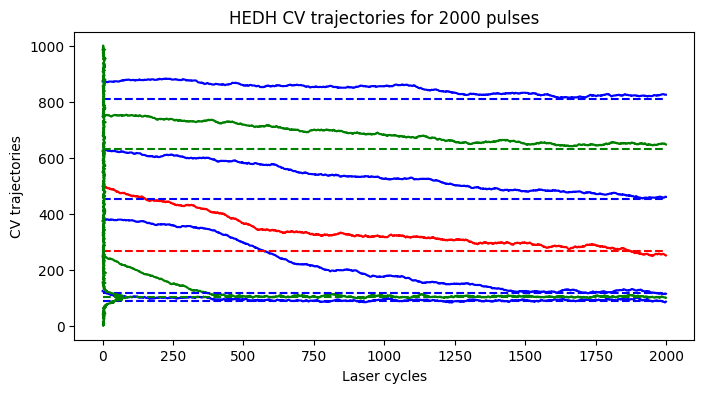

In [24]:
spc1 = HEDHVariant1(
                Nr,
                Nc,
                N_pulses,
                device,
                N_tbins,
                N_edhbins)

postproc = PostProcEDH(Nr, Nc, N_tbins, PixLdr.tmax, PixLdr.device)

captured_data = spc1.capture(phi_bar)
pedh_data = captured_data["edh"]
oedh_data = captured_data["oedh"]
ewh_data = captured_data["ewh"]
edh_list = captured_data["traj"]
edh_list = np.array(edh_list)

ROW, COL = [0,0]
fig1, ax1 = plt.subplots(1,1, figsize=(8,4))
plot_edh_traj(ax1, edh_list, oedh_data[ROW,COL,1:-1].cpu().numpy(), ewh_data[0,0,:].cpu().numpy())
ax1.set_title(r'HEDH CV trajectories for %d pulses'%(spc1.N_pulses))

## Creating a custom HEDH variant2

Variant 2 enables all the binners to update for the complete exposure time but the step size is adaptive and is proportional to the difference between early and late photons.

In [26]:

# Crearting the HEDH variant class
class HEDHVariant2(HEDHBaseClass):
  def __init__(self,
               Nr,
               Nc,
               N_pulses,
               device,
               N_tbins,
               N_edhbins,
               dead_time = 0,
               seed = 0,
               save_traj = True,
               pix_r = 0,
               pix_c = 0,
               step_params = {}):
    HEDHBaseClass.__init__(
              self,
              Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              seed = seed,
              save_traj = save_traj,
              pix_r = pix_r,
              pix_c = pix_c,
              step_params = step_params)

  # Overloading method to set the step size = 1 for all the laser cycles. Unlike
  # baseclass this removes the requirement of N_pulses to be multiple of N_levels
  def set_decay_schedule(self):
    r""" Method to set the stepping schedule for 16 bin EDH
    """
    self.decay_schedule = []

    for i in range(self.N_pulses):
      self.decay_schedule.append(1)


  # Overload the method to enable all the binners to update for the complete exposure time
  def update_delta_mask(self):
    self.delta_mask = self.delta_mask*0 + 1

  # Almost similar to the base HEDHClass except the step size depends on
  # delat and not just the sign of delta
  def update_edh(self, hist):
    r""" Update method for proportional EDH
    """

    self.decay = self.decay_schedule[self.cy_cnt]
    self.update_delta_mask()

    ts, hist = self.get_ts_from_hist(hist)
    self.update_pa_pb_kp(hist, ts)
    self.update_delta()

    new_step = (self.delta*self.k).to(self.device)

    self.prev_step = new_step*self.decay

    self.apply_edh_step()

    self.edh_bins[:,:,1:-1] = self.e1*1.0

    self.cy_cnt+=1

    # # Uncomment the following line to test if boundaries are crossing!!
    # print(torch.sum(torch.diff(self.e1, axis=-1)<0))

    return self.e1


100%|██████████| 2000/2000 [00:05<00:00, 337.68it/s]

(2000, 7)
(7,)


Text(0.5, 1.0, 'HEDH CV trajectories for 2000 pulses')

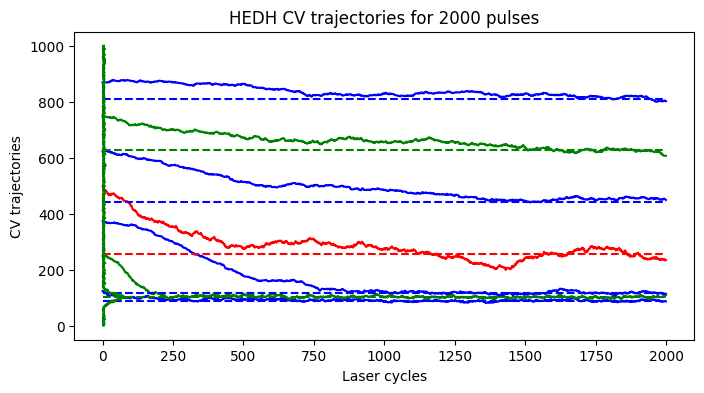

In [27]:
spc1 = HEDHVariant2(
                Nr,
                Nc,
                N_pulses,
                device,
                N_tbins,
                N_edhbins)

postproc = PostProcEDH(Nr, Nc, N_tbins, PixLdr.tmax, PixLdr.device)

captured_data = spc1.capture(phi_bar)
pedh_data = captured_data["edh"]
oedh_data = captured_data["oedh"]
ewh_data = captured_data["ewh"]
edh_list = captured_data["traj"]
edh_list = np.array(edh_list)

ROW, COL = [0,0]
fig1, ax1 = plt.subplots(1,1, figsize=(8,4))
plot_edh_traj(ax1, edh_list, oedh_data[ROW,COL,1:-1].cpu().numpy(), ewh_data[0,0,:].cpu().numpy())
ax1.set_title(r'HEDH CV trajectories for %d pulses'%(spc1.N_pulses))

Observe how the adaptive stepping allows binners converge faster in sparse photon region (region away from peak)

## Creating a custom PEDH variant1

This variant of PEDH class updates the EDH boundaries after every 5 laser cycles instead of updating every laser cycle.

In [60]:

class PEDHVariant1(PEDHBaseClass):
  def __init__(self,
               Nr,
               Nc,
               N_pulses,
               device,
               N_tbins,
               N_edhbins,
               seed=0,
               save_traj = True,
               pix_r = 0,
               pix_c = 0,
               wait_cycles = 5,
               step_params = {}):

    PEDHBaseClass.__init__(
                            self,
                            Nr,
                            Nc,
                            N_pulses,
                            device,
                            N_tbins,
                            N_edhbins,
                            seed = seed,
                            save_traj = True,
                            pix_r = pix_r,
                            pix_c = pix_c,
                            step_params=step_params)

    self.wait_cycles = wait_cycles
    self.avg_new_step = 0

  def update_edh(self, hist):
    r""" Update method applying temporal decay and temporal smoothing and scaling based on
    optimized stepping strategy for PEDH.
    """

    self.decay = self.decay_schedule[self.cy_cnt]

    ts, hist = self.get_ts_from_hist(hist)

    self.update_pa_pb_kp(hist, ts)

    self.update_delta()

    # Applying scaling on step size
    self.avg_new_step = (self.avg_new_step + (self.delta*self.k)).to(self.device)

    # Updating the binners only after every `wait_cycles` cycles
    if (self.cy_cnt%self.wait_cycles == 0) and (self.cy_cnt):

      new_step = self.avg_new_step*1.0

      # Applying temporal smoothing and decay on the step size
      self.prev_step = new_step*self.decay

      # Appying the final update step
      self.apply_edh_step()

      self.avg_new_step = 0

    self.cy_cnt+=1

    return self.e1

Increasing the wait cycle significantly affects the binner trajectories

100%|██████████| 2000/2000 [00:02<00:00, 687.08it/s]

(2000, 7)
(7,)


Text(0.5, 1.0, 'HEDH CV trajectories for 2000 pulses')

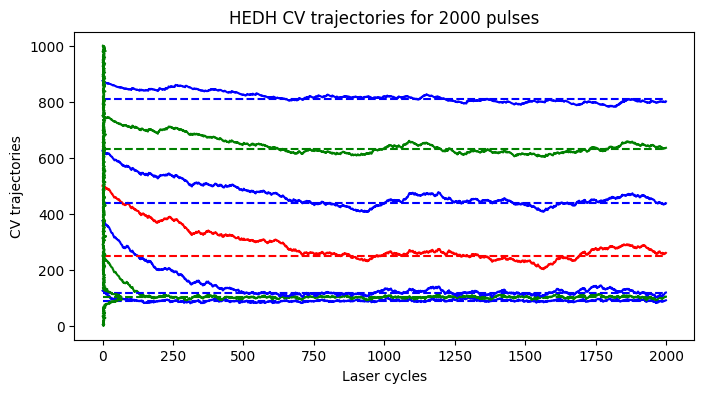

In [62]:
N_pulses = 2000
wait_cycles = 1
step_params = {"k":5}
spc1 = PEDHVariant1(
                Nr,
                Nc,
                N_pulses,
                device,
                N_tbins,
                N_edhbins,
                wait_cycles=wait_cycles,
                step_params = step_params)

postproc = PostProcEDH(Nr, Nc, N_tbins, PixLdr.tmax, PixLdr.device)

captured_data = spc1.capture(phi_bar)
pedh_data = captured_data["edh"]
oedh_data = captured_data["oedh"]
ewh_data = captured_data["ewh"]
edh_list = captured_data["traj"]
edh_list = np.array(edh_list)

ROW, COL = [0,0]
fig1, ax1 = plt.subplots(1,1, figsize=(8,4))
plot_edh_traj(ax1, edh_list, oedh_data[ROW,COL,1:-1].cpu().numpy(), ewh_data[0,0,:].cpu().numpy())
ax1.set_title(r'HEDH CV trajectories for %d pulses'%(spc1.N_pulses))

100%|██████████| 2000/2000 [00:02<00:00, 759.11it/s]


(2000, 7)
(7,)


Text(0.5, 1.0, 'HEDH CV trajectories for 2000 pulses')

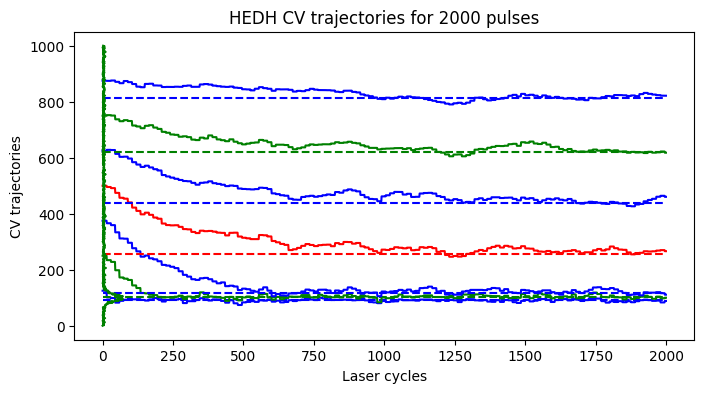

In [70]:
wait_cycles = 15
spc1 = PEDHVariant1(
                Nr,
                Nc,
                N_pulses,
                device,
                N_tbins,
                N_edhbins,
                wait_cycles=wait_cycles,
                step_params = step_params)

postproc = PostProcEDH(Nr, Nc, N_tbins, PixLdr.tmax, PixLdr.device)

captured_data = spc1.capture(phi_bar)
pedh_data = captured_data["edh"]
oedh_data = captured_data["oedh"]
ewh_data = captured_data["ewh"]
edh_list = captured_data["traj"]
edh_list = np.array(edh_list)

ROW, COL = [0,0]
fig1, ax1 = plt.subplots(1,1, figsize=(8,4))
plot_edh_traj(ax1, edh_list, oedh_data[ROW,COL,1:-1].cpu().numpy(), ewh_data[0,0,:].cpu().numpy())
ax1.set_title(r'HEDH CV trajectories for %d pulses'%(spc1.N_pulses))